In [1]:
from demodulation import *
#
import decoding as decode
import scipy
import numpy as np
import sounddevice as sd
from scipy.io.wavfile import write, read
from scipy.signal import correlate
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift
from sklearn.preprocessing import minmax_scale
import os
import math

In [2]:
SYNC_FREQ = [[348, 894], [5298, 5792]]

### Record or read

4584320


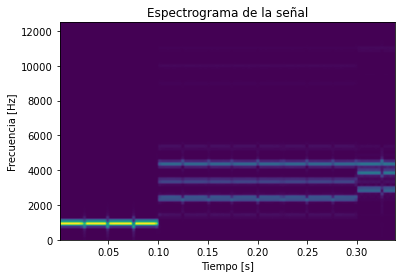

In [3]:
filename = os.path.join('D:\GitHub\EL5207_project\\ruido_desfase.wav')
# listen
# record(2, SAMPLE_FREQ, filename) 
# read
fs, audio = read(filename)
print(len(audio)) 
wave0 = filter_freq(audio, SYNC_FREQ[0][0], 100, SAMPLE_FREQ)
wave1 = filter_freq(audio, SYNC_FREQ[0][1], 100, SAMPLE_FREQ)
wave_sum = wave0 + wave1
spectrum, freqs, t, im = plt.specgram(audio[0:15000], Fs = SAMPLE_FREQ, scale = 'linear')
plt.title("Espectrograma de la señal")
plt.ylim(top=12500)
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]') 
plt.savefig("D:\GitHub\EL5207_project\informe\spectro_close.pdf")
plt.show()

In [4]:
def get_two_max_indices(arr):
    sorted_indices = np.argsort(arr)
    max_indices = sorted_indices[-2:]
    return max_indices

In [5]:
# build the start and end signal
def bfsk_modulate(bit_array, space_freq, mark_freq, baud, sample_rate):
    seconds_per_bit = 1 / baud
    samples_per_bit = int(sample_rate * seconds_per_bit)
    t = np.linspace(0, seconds_per_bit, samples_per_bit)
    space = np.sin(space_freq * 2 * np.pi * t)
    mark = np.sin(mark_freq * 2 * np.pi * t)
    signal = np.array([])
    for bit in bit_array:
        if bit == 0:
            signal = np.append(signal, space)
        elif bit == 1:
            signal = np.append(signal, mark)
    return signal

ref = bfsk_modulate([1,1,0,0], 348, 894, 16, 44100)

In [16]:
def sample_sync(audio, max_corr, max_idx, ref):
    audio_size = len(audio)
    samples_per_bit = int(SAMPLE_FREQ / BAUD)
    last_starter = (audio_size - 1)*4*samples_per_bit
    # Left
    ewe = []
    print("left")
    for i in range((samples_per_bit<<2) - 1):
        print(i)
        if((max_idx == 0)):
            break
        else:
            y_w = audio[max_idx - 1:max_idx - 1 + len(ref)]
            cor = correlate(ref, y_w, mode='full', method='fft')
            ewe.append(sum(cor**2))
            if ((sum(cor**2)/max_corr) > 1.01):
                # print(sum(cor**2)/max_corr)
                max_corr = sum(cor**2)
                max_idx = max_idx - 1
            else:
                print(f"i break {(sum(cor**2)/max_corr)}")
                break
    # Right
    print("right")
    for i in range((samples_per_bit << 2) - 1):
        print(i)
        if((max_idx >= last_starter)):
            break
        else:
            y_w = audio[max_idx + 1:max_idx + 1 + len(ref)]
            cor = correlate(ref, y_w, mode='full', method='fft')
            # print(sum(cor**2))
            ewe.append(sum(cor**2))
            if ((sum(cor**2)/max_corr) > 1.01):

                print(sum(cor**2)/max_corr)
                max_corr = sum(cor**2)
                max_idx = max_idx + 1
            else:
                print(f"i break {(sum(cor**2)/max_corr)}")
                break
    return max_idx, ewe


In [18]:
def sync_detect(audio, sync_freq, mode = "img"):
    # Filter in the frequency
    wave0 = filter_freq(audio, sync_freq[0], 50, SAMPLE_FREQ)
    wave1 = filter_freq(audio, sync_freq[1], 50, SAMPLE_FREQ)
    wave_sum = wave0 + wave1
    # get the reference
    ref_init = bfsk_modulate([1, 1, 1, 1], sync_freq[0], sync_freq[1], BAUD, SAMPLE_FREQ)
    ref_end = bfsk_modulate([0, 0, 0, 0], sync_freq[0], sync_freq[1], BAUD, SAMPLE_FREQ)
    # From this we get the peaks
    start = 0
    end = 0
    #
    corr_init = []
    corr_end = []
    for i in range(math.floor((len(wave_sum))/len(ref_init))):
        y_w = wave_sum[i* len(ref_init):(i+1) * len(ref_init)]
        cor = correlate(ref_init, y_w, mode='full', method='fft')
        corr_init.append(sum(cor**2))
        y_x = wave_sum[i* len(ref_end):(i+1) * len(ref_end)]
        cor = correlate(ref_end, y_x, mode='full', method='fft')
        corr_end.append(sum(cor**2)) 
    # return audio[start:end]
    if (mode == "img"):
        start = np.min(get_two_max_indices(corr_init))
        end = np.min(get_two_max_indices(corr_end))
    else: # text
        start = np.max(get_two_max_indices(corr_init))
        end = np.max(get_two_max_indices(corr_end))
    start_corr = corr_init[start]
    end_corr = corr_end[end]
    # Get the location in sample points
    samples_per_bit = int(SAMPLE_FREQ / BAUD)
    bit_start = int(((start + 1)*samples_per_bit)<<2)
    bit_end = int(((end)*samples_per_bit)<<2)
    # Check the maximum bit-wise locally
    bit_start = sample_sync(wave_sum, start_corr, bit_start, ref_init)
    print(bit_start[1])
    bit_start = bit_start[0]
    bit_end = sample_sync(wave_sum, end_corr, bit_end, ref_end)
    print(bit_end[1])
    bit_end = bit_end[0]
    print(bit_start, bit_end)

    plt.plot(corr_init)
    plt.title("Correlación de bits de inicio, emisor 2")
    plt.xlabel('Ventana')
    plt.ylabel('Correlación') 
    plt.savefig("D:\GitHub\EL5207_project\informe\corr_init2.pdf")
    plt.show()
    plt.plot(corr_end)
    plt.title("Correlación de bits de término, emisor 2")
    plt.xlabel('Ventana')
    plt.ylabel('Correlación') 
    plt.savefig("D:\GitHub\EL5207_project\informe\corr_end2.pdf")
    plt.show()
    # print(start, end)
    # print(len(audio) - start)
    print(bit_start, bit_end)
    return audio[bit_start:bit_end]

left
0
i break 0.12055965014851354
right
0
i break 0.1198497913106569
[1.9547125072170822e+17, 1.9432031013171178e+17]
left
0
i break 0.999722026075721
right
0
i break 0.9999616531275083
[5.4613426723438035e+17, 5.462651721668755e+17]
2159920 3200208


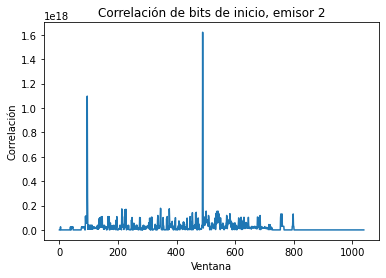

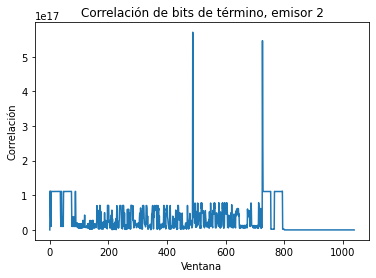

2159920 3200208


In [19]:
SYNC_FREQ = [[348, 894], [5298, 5792]] 
wave = sync_detect(audio, SYNC_FREQ[1], mode = "text")

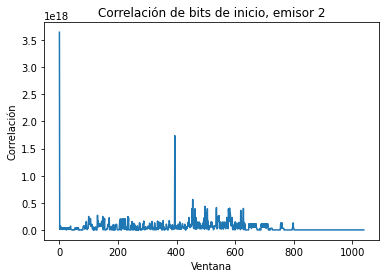

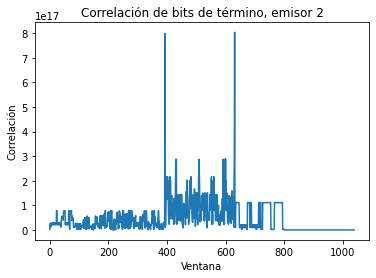

1741160 2781446


In [22]:
SYNC_FREQ = [[348, 894], [5298, 5792]] 
wave = sync_detect(audio, SYNC_FREQ[1], mode = "text")

In [61]:
points = np.linspace(0, 1, int(SAMPLE_FREQ*1))
awa = signal.chirp(points, 348, 1, 894)
ewo = signal.chirp(points, 894, 1, 348)
awa = np.append(awa, ewo)

In [69]:
sync_freq = SYNC_FREQ[0]
points = np.linspace(0, 1, int(SAMPLE_FREQ*1))
init0 = signal.chirp(points, sync_freq[0], 1, sync_freq[1])
init1 = signal.chirp(points, sync_freq[1], 1, sync_freq[0])
ref_init = np.append(init0, init1)
ref_end = np.append(init1, init0)

In [71]:
from IPython.display import Audio
Audio(ref_init, rate=SAMPLE_FREQ)

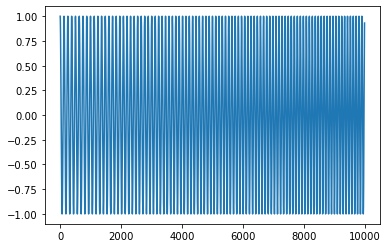

In [65]:
plt.plot(awa[0:10000])